<a href="https://colab.research.google.com/github/naemililia/masterthesis/blob/main/pipeline_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is optimized for google colab

immer am anfang:
- alignment helpers hochladen, da dessen Funktionen genutzt werden



In [ ]:
# define which auxiliary information i want to create labels for now, and also which satellite source

UNLABELED_DATASET = 'Sen1floods11'
AUXILIARY_DATASOURCE = 'BUILT' # 'LC', 'BUILT'


In [ ]:
# installations
!pip install utm
!pip install rasterio

  Preparing metadata (setup.py) ... done
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6084 sha256=d798f71e6ddfca71a4e201f359bff5e9834cc711c52b13531916d4202724750b
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 45.3 MB/s eta 0:00:00


In [ ]:
import sys
import os
import shutil
from tqdm import tqdm
import utm
import rasterio
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import numpy as np
from pathlib import Path


In [ ]:
# import my own file with helper functions
sys.path.append('/content')
from alignment_helpers import *

In [ ]:
# mount drive to access aux data, and to save labels
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# download flood data
!gsutil cp gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_train_data.csv .
!gsutil cp gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_test_data.csv .
!gsutil cp gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_valid_data.csv .

Copying gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_train_data.csv...
/ [1 files][ 13.3 KiB/ 13.3 KiB]                                                
Operation completed over 1 objects/13.3 KiB.                                     
Copying gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_test_data.csv...
/ [1 files][  4.7 KiB/  4.7 KiB]                                                
Operation completed over 1 objects/4.7 KiB.                                      
Copying gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_valid_data.csv...
/ [1 files][  4.7 KiB/  4.7 KiB]                                                
Operation completed over 1 objects/4.7 KiB.                                      


In [ ]:
# download all files into S1weak_all (we now want the weakly labeled satellite images, not the hand labeled ones)

!sudo mkdir files
#!sudo mkdir files/S1perm # decided against S1perm for now, as i want to use the flood data and ifnetune on flood data, + the perm data would mean that i need to download a lot more auxiliary info
!sudo mkdir files/S1weak_all

#!gsutil -m rsync -r gs://sen1floods11/v1.1/data/perm_water/S1Perm files/S1perm
!gsutil -m rsync -r gs://sen1floods11/v1.1/data/flood_events/WeaklyLabeled/S1Weak files/S1weak_all


both the source and destination. Your crcmod installation isn't using the
module's C extension, so checksumming will run very slowly. If this is your
first rsync since updating gsutil, this rsync can take significantly longer than
usual. For help installing the extension, please see "gsutil help crcmod".

Building synchronization state...
Starting synchronization...
Copying gs://sen1floods11/v1.1/data/flood_events/WeaklyLabeled/S1Weak/Bolivia_1163442_S1Weak.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/WeaklyLabeled/S1Weak/Bolivia_1009032_S1Weak.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/WeaklyLabeled/S1Weak/Bolivia_1264498_S1Weak.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/WeaklyLabeled/S1Weak/Bolivia_1159714_S1Weak.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/WeaklyLabeled/S1Weak/Bolivia_1041766_S1Weak.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/WeaklyLabeled/S1Weak/Bolivia_1037580_S1Weak.tif...
Copying gs://sen1floods11/v1.1

In [ ]:
# Create subfolders from the S1Weak folder of 500 images each to create batches for better handling and supervision (if connection is lost etc)

source_dir = '/content/files/S1weak_all'
files = os.listdir(source_dir)
batch_size = 500

for i in range(0, len(files), batch_size):
    # Create batch directory
    batch_dir = os.path.join('/content/files/S1weak', f'batch_{i//batch_size + 1}')
    os.makedirs(batch_dir, exist_ok=True)

    # Move files in batches
    for file in files[i:i+batch_size]:
        shutil.move(os.path.join(source_dir, file), batch_dir)

In [ ]:
def load_ghsl_shapefile():
  """
  This function loads the shapefile provided by the GHSL into a dataframe and adds the tile_ids (also provided by them) as a column
  """
  shapefile = gpd.read_file('/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/BUILT/shape/WGS84_tile_schema.shp')
  tile_ids = pd.read_csv('/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/BUILT/shape/WGS84_tile_schema.csv', header=None)
  shapefile['tile_id'] = tile_ids

  return shapefile

In [ ]:
def resize_the_label(array_label):
  """
  This function resized the labels to the size of the input images from the unlabeled data source.

  Depending on the auxiliary data, different orders of zoom are used.

  for BUILT and POP, both continuous, regression like variables, order = 1, making it a trilinear interpolation (https://labs.quansight.org/blog/2021/01/scipy-ndimage-interpolation) / bilinear interpolation (chatgpt)

  for LC, a variable with a discrete amount of classes, order = 0, making it a nearest neighbor resizing process
  """
  original_shape = array_label.shape

  if UNLABELED_DATASET == 'Sen1floods11':
    new_shape = (512, 512)
  elif UNLABELED_DATASET == 'EuroSAT':
    new_shape = (64, 64)

  zoom_factors = [n / o for n, o in zip(new_shape, original_shape)]

  if AUXILIARY_DATASOURCE == 'BUILT' or AUXILIARY_DATASOURCE == 'POP':
    order = 1
  elif AUXILIARY_DATASOURCE == 'LC':
    order = 0

  resized_label = zoom(array_label, zoom_factors, order = order)

  return resized_label


In [ ]:
def save_label_for_image(file, label_array, save_dir):
    """
    saves the label as a numpy array to the specified save_dir, using the name of the file, and appending '_label'
    """

    # Extract the base name without the extension
    base_name = file.stem
    label_filename = f"{base_name}_label.npy"
    label_path = os.path.join(save_dir, label_filename)
    np.save(label_path, label_array)

def save_resized_label_for_image(file, label_array, save_dir):
    """
    saves the resized label as a numpy array to the specified save_dir, using the name of the file, and appending '_label_resized'
    """
    # Extract the base name without the extension
    base_name = file.stem
    label_filename = f"{base_name}_label_resized.npy"
    label_path = os.path.join(save_dir, label_filename)
    np.save(label_path, label_array)

In [ ]:
def save_array_of_problematic_images(save_dir, list_of_files_in_multiple_tiles):
    """
    Some unlabeled satellite images are spread across multiple auxiliary tiles
    --> these ones are saved in a list, which is saved with this function in the same directory as the labels
    """
    with open(save_dir +'/list_of_files_in_multiple_tiles.txt', 'w') as f:
      for item in list_of_files_in_multiple_tiles:
          f.write("%s\n" % item)

In [ ]:
# PIPELINE

#test_path = Path('/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/flood')
base_path = Path('/content/files/S1weak/')
# initialize empty list to save the images which are spread across multiple aux info tiles
list_of_files_in_multiple_tiles = []
# initialize filecounter, used to print progress
file_counter = 0

for batch_folder in base_path.iterdir():
    if batch_folder.is_dir() and batch_folder.stem != '.ipynb_checkpoints':
      print(batch_folder.stem)
      for file in batch_folder.iterdir():
          if file.is_file() and file.suffix == '.tif':# and file.stem not in unique_filenames_list:
            # do some tracking
            print(file.stem)
            file_counter += 1
            if file_counter % 10 == 0:
                print(f'file {file_counter}')

            # read the raw satelite image and save its transform matrix and the array
            with rasterio.open(file) as src:
              array_sat = src.read(1)
              transform_sat = src.transform

              if UNLABELED_DATASET == 'EuroSAT':
                # if we have a eurosat image, then also save the coordinate system as a string, in order to extract the UTM zone
                crs_str = str(src.crs)

            # step 1: get the corner coordinates of the satellite image
            corner_coordinates = get_coordinates_of_corners(transform_sat, array_sat)
            if UNLABELED_DATASET == 'EuroSAT':
              # extract UTM zone and hemisphere first
              zone_nr, hemisphere = find_UTM_zone_eurosat(crs_str)
              corner_coordinates = get_coordinates_of_corners_from_UTM(zone_nr, corner_coordinates)

            # step 2: identify the correct tile of auxiliary info to download.
            # If the event is at the border of multiple tiles, then add the file name to a list, and skip the file for now
            if AUXILIARY_DATASOURCE == 'BUILT' or AUXILIARY_DATASOURCE == 'POP':
              shapefile = load_ghsl_shapefile()
              tile_id = get_BUILT_polygon_encircling_unlabeled_staelite_image(shapefile, corner_coordinates)
              if tile_id:
                file_name = 'GHS_' + AUXILIARY_DATASOURCE + '_E2020_GLOBE_R2023A_4326_3ss_V1_0_' + tile_id # wenn man es mit BUILT laufen lässt, dann noch _S_ vor E2020

              else:
                list_of_files_in_multiple_tiles.append(file)
                continue


            elif AUXILIARY_DATASOURCE == 'LC':
              tile_id = find_correct_land_cover_tile(corner_coordinates)
              if tile_id:
                file_name = tile_id + '_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326'
              else:
                list_of_files_in_multiple_tiles.append(file.stem)
                continue

            # step 3: load the correct tile of the auxiliary data source
            folder_name = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/'+ AUXILIARY_DATASOURCE + '/'
            with rasterio.open(folder_name + file_name + '.tif') as src:
              array_aux = src.read(1)
              transform_aux = src.transform

            # step 4: get the pixel coordinates for the geo-coordinates
            corner_pixels_aux = get_corner_pixels(corner_coordinates, transform_aux)

            # step 5: slice away the label
            label = get_label_from_pixel(corner_pixels_aux, array_aux)

            # save the 'raw' label to google drive
            save_dir = '/content/drive/My Drive/Uni/TUB/Semester/5 - Masterarbeit/data/'+AUXILIARY_DATASOURCE+ '/' + UNLABELED_DATASET
            save_label_for_image(file,label, save_dir)

            # step 6: resize the label
            resized_label = resize_the_label(label)

            # save the resized label to google drive
            save_resized_label_for_image(file,resized_label, save_dir)

      # save the problematic images to the same directory
      save_array_of_problematic_images(save_dir, list_of_files_in_multiple_tiles)






Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Somalia_151588_S1Weak
R9_C23 is the only tile to download
Colombia_9911520_S1Weak
R9_C12 is the only tile to download
Paraguay_2834197_S1Weak
R12_C13 is the only tile to download
Spain_1937976_S1Weak
R6_C18 is the only tile to download
Mekong_5207699_S1Weak
file 2010
R8_C29 is the only tile to download
Somalia_6438874_S1Weak
R9_C23 is the only tile to download
Ghana_2092661_S1Weak
R8_C18 is the only tile to download
Pakistan_697548_S1Weak
R6_C26 is the only tile to download
Sri-Lanka_3944881_S1Weak
R9_C27 is the only tile to download
Colombia_7150418_S1Weak
R9_C12 is the only tile to download
Pakistan_635539_S1Weak
R6_C26 is the only tile to download
Paraguay_7746346_S1Weak
R12_C13 is the only tile to download
Paraguay_3253224_S1Weak
R12_C13 is the only tile to download
India_3154844_S1Weak
R7_C28 is the only tile to download
Paraguay_6979890_S1Weak
file 2020
R12_C13 is the only tile to download
India_9468827_S1Weak
R7_

In [ ]:
# PIPELINE

#test_path = Path('/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/flood')
base_path = Path('/content/files/S1/')
# initialize empty list to save the images which are spread across multiple aux info tiles
list_of_files_in_multiple_tiles = []
# initialize filecounter, used to print progress
file_counter = 0


for file in batch_folder.iterdir():
    if file.is_file() and file.suffix == '.tif':# and file.stem not in unique_filenames_list:
      # do some tracking
      print(file.stem)
      file_counter += 1
      if file_counter % 10 == 0:
          print(f'file {file_counter}')

      # read the raw satelite image and save its transform matrix and the array
      with rasterio.open(file) as src:
        array_sat = src.read(1)
        transform_sat = src.transform

        if UNLABELED_DATASET == 'EuroSAT':
          # if we have a eurosat image, then also save the coordinate system as a string, in order to extract the UTM zone
          crs_str = str(src.crs)

      # step 1: get the corner coordinates of the satellite image
      corner_coordinates = get_coordinates_of_corners(transform_sat, array_sat)
      if UNLABELED_DATASET == 'EuroSAT':
        # extract UTM zone and hemisphere first
        zone_nr, hemisphere = find_UTM_zone_eurosat(crs_str)
        corner_coordinates = get_coordinates_of_corners_from_UTM(zone_nr, corner_coordinates)

      # step 2: identify the correct tile of auxiliary info to download.
      # If the event is at the border of multiple tiles, then add the file name to a list, and skip the file for now
      if AUXILIARY_DATASOURCE == 'BUILT' or AUXILIARY_DATASOURCE == 'POP':
        shapefile = load_ghsl_shapefile()
        tile_id = get_BUILT_polygon_encircling_unlabeled_staelite_image(shapefile, corner_coordinates)
        if tile_id:
          file_name = 'GHS_' + AUXILIARY_DATASOURCE + '_E2020_GLOBE_R2023A_4326_3ss_V1_0_' + tile_id # wenn man es mit BUILT laufen lässt, dann noch _S_ vor E2020

        else:
          list_of_files_in_multiple_tiles.append(file)
          continue


      elif AUXILIARY_DATASOURCE == 'LC':
        tile_id = find_correct_land_cover_tile(corner_coordinates)
        if tile_id:
          file_name = tile_id + '_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326'
        else:
          list_of_files_in_multiple_tiles.append(file.stem)
          continue

      # step 3: load the correct tile of the auxiliary data source
      folder_name = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/'+ AUXILIARY_DATASOURCE + '/'
      with rasterio.open(folder_name + file_name + '.tif') as src:
        array_aux = src.read(1)
        transform_aux = src.transform

      # step 4: get the pixel coordinates for the geo-coordinates
      corner_pixels_aux = get_corner_pixels(corner_coordinates, transform_aux)

      # step 5: slice away the label
      label = get_label_from_pixel(corner_pixels_aux, array_aux)

      # save the 'raw' label to google drive
      save_dir = '/content/drive/My Drive/Uni/TUB/Semester/5 - Masterarbeit/data/'+AUXILIARY_DATASOURCE+ '/' + UNLABELED_DATASET
      save_label_for_image(file,label, save_dir)

      # step 6: resize the label
      resized_label = resize_the_label(label)

      # save the resized label to google drive
      save_resized_label_for_image(file,resized_label, save_dir)

# save the problematic images to the same directory
save_array_of_problematic_images(save_dir, list_of_files_in_multiple_tiles)






Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Somalia_151588_S1Weak
R9_C23 is the only tile to download
Colombia_9911520_S1Weak
R9_C12 is the only tile to download
Paraguay_2834197_S1Weak
R12_C13 is the only tile to download
Spain_1937976_S1Weak
R6_C18 is the only tile to download
Mekong_5207699_S1Weak
file 2010
R8_C29 is the only tile to download
Somalia_6438874_S1Weak
R9_C23 is the only tile to download
Ghana_2092661_S1Weak
R8_C18 is the only tile to download
Pakistan_697548_S1Weak
R6_C26 is the only tile to download
Sri-Lanka_3944881_S1Weak
R9_C27 is the only tile to download
Colombia_7150418_S1Weak
R9_C12 is the only tile to download
Pakistan_635539_S1Weak
R6_C26 is the only tile to download
Paraguay_7746346_S1Weak
R12_C13 is the only tile to download
Paraguay_3253224_S1Weak
R12_C13 is the only tile to download
India_3154844_S1Weak
R7_C28 is the only tile to download
Paraguay_6979890_S1Weak
file 2020
R12_C13 is the only tile to download
India_9468827_S1Weak
R7_

/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/POP/Sen1floods11/Colombia_3986001_S1Weak_label.npy
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


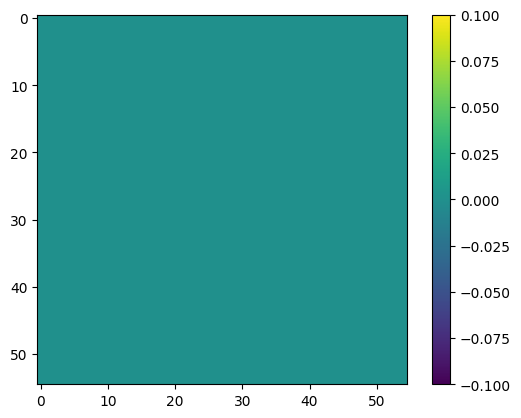

unique values: [0.]
/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/POP/Sen1floods11/Colombia_3986001_S1Weak_label_resized.npy
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


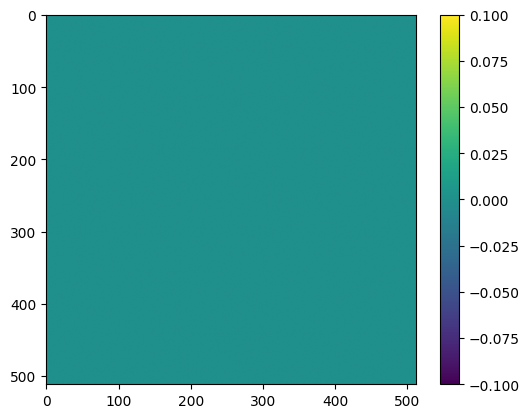

unique values: [0.]
/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/POP/Sen1floods11/Ghana_3527966_S1Weak_label.npy
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


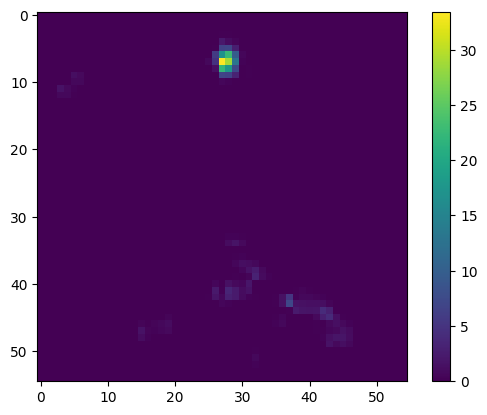

unique values: [0.00000000e+00 2.05390397e-03 2.05390401e-03 2.46468477e-03
 3.69702715e-03 4.16743308e-03 4.92936954e-03 5.47707736e-03
 8.21561605e-03 8.33486617e-03 9.58488539e-03 1.23234245e-02
 1.38914436e-02 1.53358173e-02 1.64312321e-02 1.64312327e-02
 1.66697323e-02 1.66697323e-02 1.71158666e-02 1.82112825e-02
 1.84851361e-02 1.91697717e-02 1.94480217e-02 2.05390409e-02
 2.22263098e-02 2.38932848e-02 2.46468490e-02 2.68376803e-02
 2.87546572e-02 2.97131446e-02 3.28624651e-02 3.28624654e-02
 3.45055890e-02 3.64225650e-02 3.83395433e-02 4.11186743e-02
 4.24473508e-02 4.44526196e-02 4.50489613e-02 4.66752529e-02
 4.72309089e-02 4.77865696e-02 4.92936963e-02 5.13476014e-02
 5.47707736e-02 5.50101185e-02 5.75093150e-02 5.83440650e-02
 5.83440650e-02 6.02478504e-02 6.03847776e-02 6.94572210e-02
 7.16798496e-02 7.64029408e-02 7.73637176e-02 8.00147152e-02
 8.08482042e-02 8.22373483e-02 8.33486617e-02 8.33486652e-02
 8.62639725e-02 9.36580220e-02 9.44618225e-02 9.55731392e-02
 9.968280

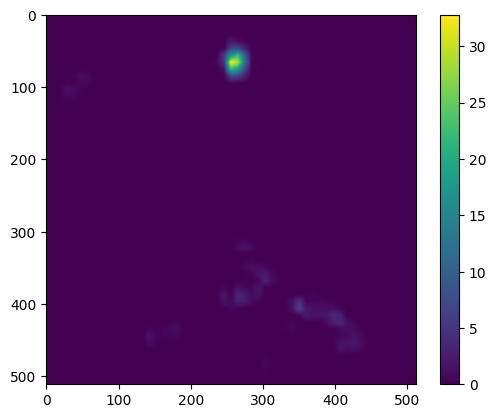

unique values: [0.00000000e+00 1.51021773e-06 1.78749514e-06 ... 3.23056266e+01
 3.23499641e+01 3.27952067e+01]
/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/POP/Sen1floods11/India_1915393_S1Weak_label.npy
[[ 2.60949018  5.58908083  2.80810975 ...  2.32408657  1.23018826
   0.        ]
 [ 3.12661671  8.94980608  2.83912533 ...  9.22298237  4.30640451
   0.94299524]
 [ 0.58631519  0.          3.85906342 ...  7.16431837  5.13517874
   7.76554501]
 ...
 [ 0.          0.          0.         ...  2.55819518  0.02684047
   0.        ]
 [ 0.          0.          0.         ...  9.18540568  1.58657007
   0.01789365]
 [ 0.          0.          0.         ... 12.1793111   4.77998961
   0.02982275]]


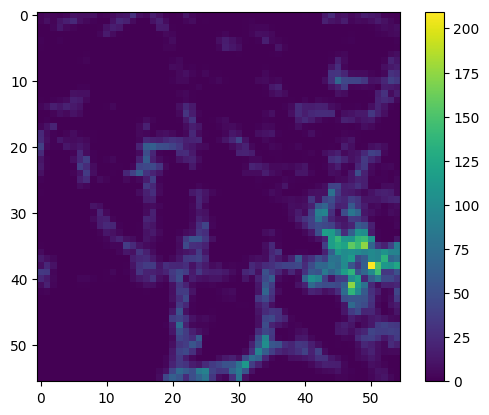

unique values: [0.00000000e+00 8.94682407e-04 1.49113730e-03 ... 1.73948625e+02
 1.74289495e+02 2.09508966e+02]
/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/POP/Sen1floods11/India_1915393_S1Weak_label_resized.npy
[[2.60949018 2.92435885 3.23922753 ... 0.26000065 0.13000032 0.        ]
 [2.66514959 3.01236146 3.35957334 ... 0.41002387 0.25576021 0.10149655]
 [2.720809   3.10036407 3.47991915 ... 0.5600471  0.3815201  0.20299311]
 ...
 [0.         0.         0.         ... 0.88645844 0.45685664 0.02725484]
 [0.         0.         0.         ... 0.96011517 0.49432698 0.02853879]
 [0.         0.         0.         ... 1.03377191 0.53179733 0.02982275]]


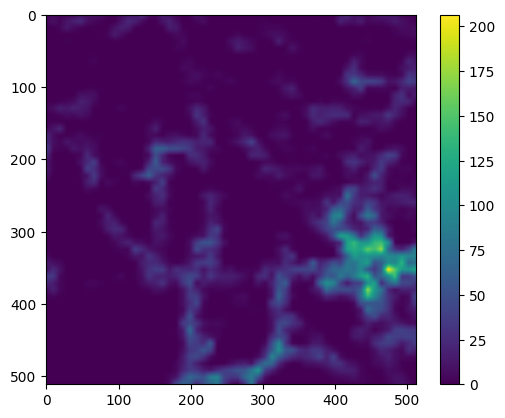

unique values: [0.00000000e+00 8.56578375e-08 2.74105080e-07 ... 1.97496566e+02
 2.03629186e+02 2.06564315e+02]
/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/POP/Sen1floods11/India_1796024_S1Weak_label.npy
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


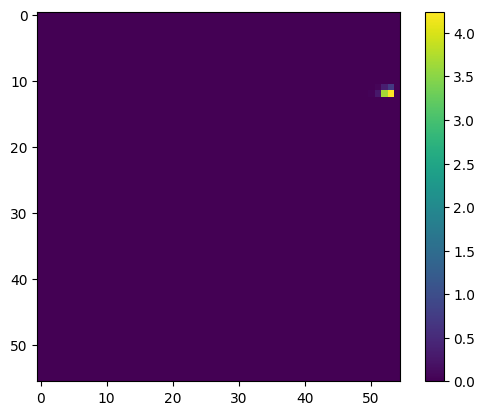

unique values: [0.         0.04079946 0.06119919 0.26519649 0.35359531 0.70719063
 3.67875125 4.24314377]
/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/POP/Sen1floods11/India_1796024_S1Weak_label_resized.npy
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


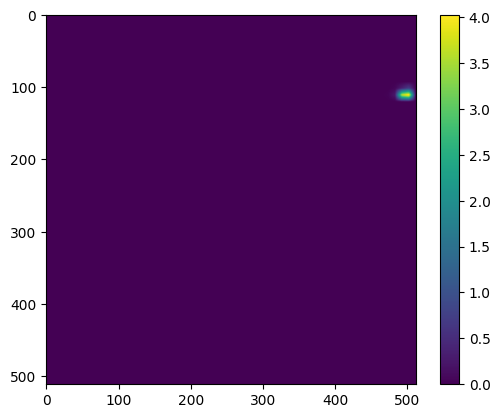

unique values: [0.00000000e+00 5.39053306e-05 1.14216802e-04 ... 3.96644933e+00
 3.98036771e+00 4.02491458e+00]
/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/POP/Sen1floods11/Mekong_34098_S1Weak_label.npy
[[2.36849304 1.2953155  0.00880723 ... 0.         0.         0.        ]
 [0.13308706 0.06523876 0.03914325 ... 0.         0.         0.        ]
 [0.10536059 0.92019267 0.29292201 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


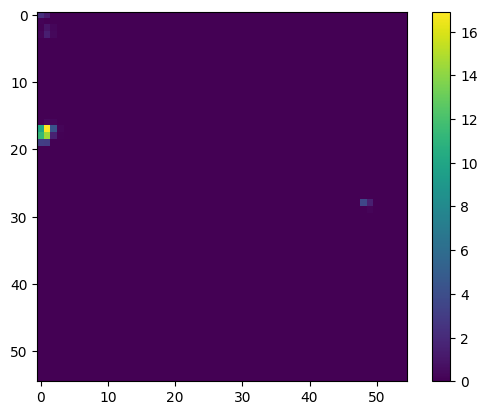

unique values: [0.00000000e+00 6.28657788e-04 8.80723178e-03 1.32018135e-02
 1.36209191e-02 3.91432536e-02 4.24051905e-02 6.36077857e-02
 6.52387559e-02 6.85006952e-02 1.05360594e-01 1.33087063e-01
 2.05502086e-01 2.10721188e-01 2.15629622e-01 2.70088463e-01
 2.92922014e-01 3.59791737e-01 4.05132694e-01 9.20192673e-01
 1.29531550e+00 1.39089031e+00 1.50877870e+00 1.55431330e+00
 2.36849304e+00 2.97521336e+00 3.11482441e+00 3.63364202e+00
 4.32924365e+00 1.00027323e+01 1.13241435e+01 1.44875698e+01
 1.69141252e+01]
/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/POP/Sen1floods11/Mekong_34098_S1Weak_label_resized.npy
[[2.36849304 2.25508485 2.14167665 ... 0.         0.         0.        ]
 [2.13226619 2.03008474 1.9279033  ... 0.         0.         0.        ]
 [1.89603933 1.80508464 1.71412994 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.   

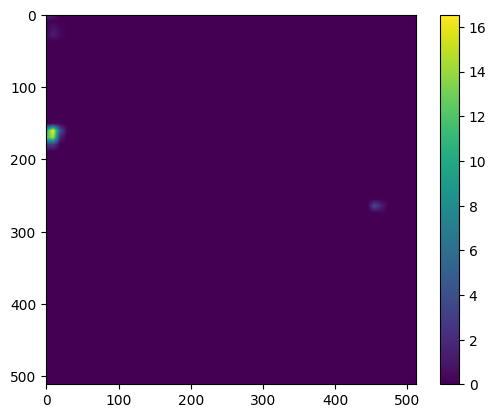

unique values: [0.00000000e+00 5.48917841e-07 1.73823983e-06 ... 1.61664034e+01
 1.63082162e+01 1.65452658e+01]
/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/POP/Sen1floods11/Nigeria_2434449_S1Weak_label.npy
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


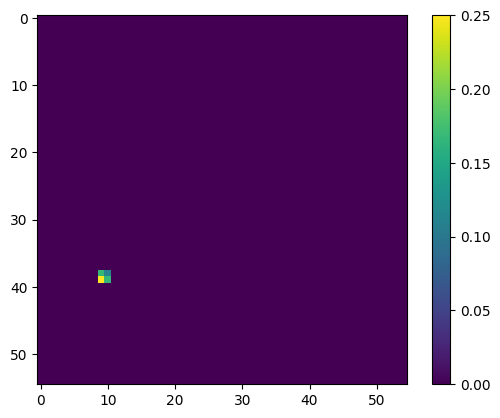

unique values: [0.         0.11130364 0.16695547 0.2504332 ]
/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/POP/Sen1floods11/Nigeria_2434449_S1Weak_label_resized.npy
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


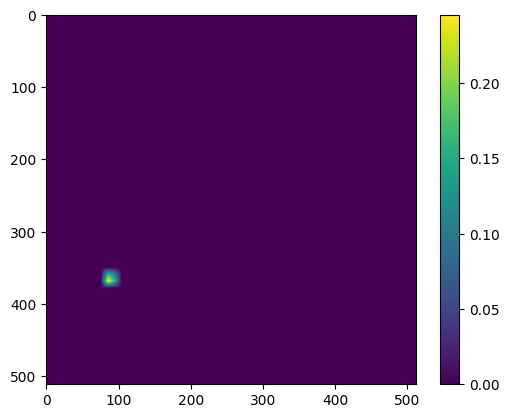

unique values: [0.00000000e+00 8.95131578e-05 1.00169486e-04 2.15257832e-04
 2.62145676e-04 3.30346178e-04 4.29663157e-04 4.34778195e-04
 4.45434523e-04 4.80813533e-04 5.60522869e-04 6.07410714e-04
 6.75611215e-04 7.80043232e-04 7.90699561e-04 9.05787906e-04
 9.52675751e-04 1.02087625e-03 1.03323759e-03 1.05625526e-03
 1.11252068e-03 1.12530827e-03 1.17006485e-03 1.18199994e-03
 1.22760902e-03 1.25829925e-03 1.28515319e-03 1.29794079e-03
 1.34269737e-03 1.40024154e-03 1.45778571e-03 1.47057331e-03
 1.51532989e-03 1.57287406e-03 1.58566165e-03 1.63041823e-03
 1.87977631e-03 2.02299737e-03 2.08693534e-03 2.10355921e-03
 2.13808571e-03 2.26383039e-03 2.54004242e-03 2.69050977e-03
 2.91557143e-03 2.98973947e-03 3.09331898e-03 3.24293383e-03
 3.32988947e-03 3.34566084e-03 3.72630488e-03 3.74420751e-03
 3.79535789e-03 3.89808490e-03 3.95648157e-03 4.34778195e-03
 4.42749129e-03 4.52041447e-03 4.57284360e-03 4.78000263e-03
 4.86482700e-03 4.90020601e-03 4.92322368e-03 5.13038270e-03
 5.256127

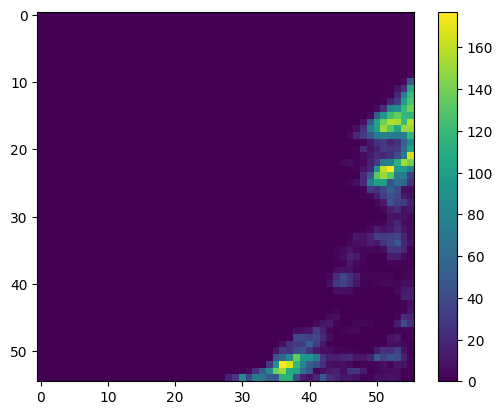

unique values: [0.00000000e+00 9.43410471e-04 2.83023141e-03 5.66046298e-03
 7.54728377e-03 7.86175355e-03 8.80516410e-03 9.43410471e-03
 1.10064554e-02 1.41511571e-02 1.57235074e-02 1.69813889e-02
 1.76103288e-02 1.79247989e-02 2.04405594e-02 2.51576114e-02
 2.73589039e-02 3.39627767e-02 4.08811188e-02 4.24534714e-02
 4.65415812e-02 4.71705246e-02 5.50322771e-02 6.28940284e-02
 7.04413128e-02 9.55989277e-02 1.05661969e-01 1.14781606e-01
 1.16982901e-01 1.17926306e-01 1.20756540e-01 1.51889086e-01
 1.59750843e-01 1.61952123e-01 1.65096831e-01 1.65411301e-01
 1.73901997e-01 1.76103287e-01 1.83965043e-01 2.17927823e-01
 2.59437885e-01 2.61010227e-01 2.75161381e-01 2.99375577e-01
 3.00318990e-01 3.04721575e-01 3.16042500e-01 3.44344811e-01
 3.61011734e-01 3.86169364e-01 3.90886419e-01 4.01263924e-01
 4.06295433e-01 4.10383558e-01 4.16987426e-01 4.56610680e-01
 4.67302647e-01 5.01579895e-01 5.58498974e-01 6.07556343e-01
 6.31141586e-01 6.44663849e-01 7.01897383e-01 7.73596559e-01
 7.798860

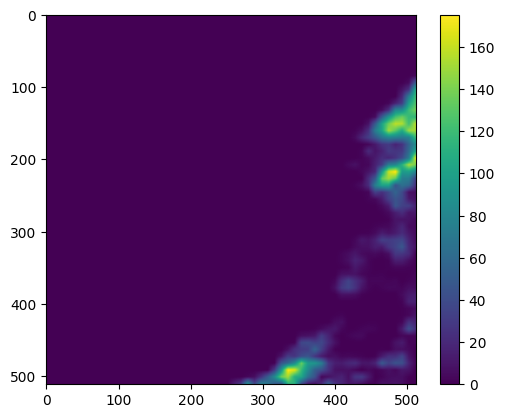

unique values: [0.00000000e+00 3.13120115e-06 5.97336830e-06 ... 1.73654582e+02
 1.74281091e+02 1.75290047e+02]
/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/POP/Sen1floods11/Paraguay_9460560_S1Weak_label.npy
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


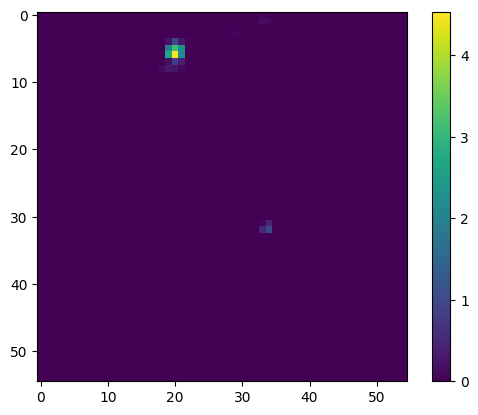

unique values: [0.00000000e+00 1.21946715e-03 2.28650093e-03 2.74380118e-03
 3.65840144e-03 3.81083488e-03 4.87786859e-03 8.38383675e-03
 9.14600372e-03 1.37190059e-02 2.71331453e-02 4.11570168e-02
 4.57300186e-02 5.16749203e-02 5.48760223e-02 8.50578308e-02
 8.61248672e-02 9.02405739e-02 1.20574814e-01 1.35665727e-01
 1.62798872e-01 1.72249734e-01 2.62795174e-01 2.70721722e-01
 2.90842918e-01 3.25597744e-01 3.72547226e-01 5.10346985e-01
 5.31077926e-01 8.39908028e-01 9.70543429e-01 1.02069397e+00
 1.94535498e+00 2.16363962e+00 2.24381958e+00 2.65874325e+00
 3.12336025e+00 4.53611296e+00]
/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/POP/Sen1floods11/Paraguay_9460560_S1Weak_label_resized.npy
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


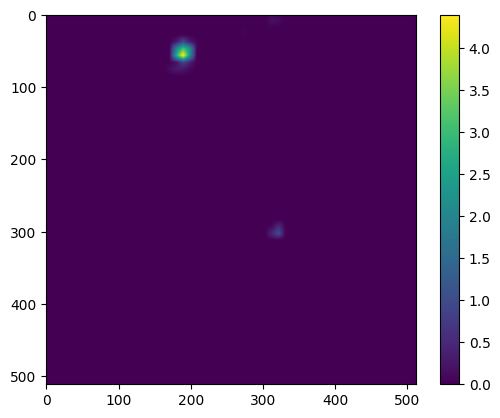

unique values: [0.00000000e+00 4.20311071e-07 1.51311985e-06 ... 4.26710346e+00
 4.37013636e+00 4.39865106e+00]
/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/POP/Sen1floods11/Sri-Lanka_5335407_S1Weak_label.npy
[[ 0.          0.          0.         ...  4.6562933   9.48127691
   8.54719578]
 [ 0.          0.          0.         ...  4.24217501  9.58337311
  13.27934393]
 [ 0.          0.          0.         ...  4.56808922  9.37521137
   8.5511648 ]
 ...
 [ 4.95376154  5.89952971 12.24052097 ...  4.0346751   0.
   2.46089378]
 [ 5.63712269  6.39325207  6.16965475 ...  9.1983622   2.04964231
   8.0512681 ]
 [ 0.85205141  4.72619493  1.50498206 ...  8.968811    3.18637238
   4.3508865 ]]


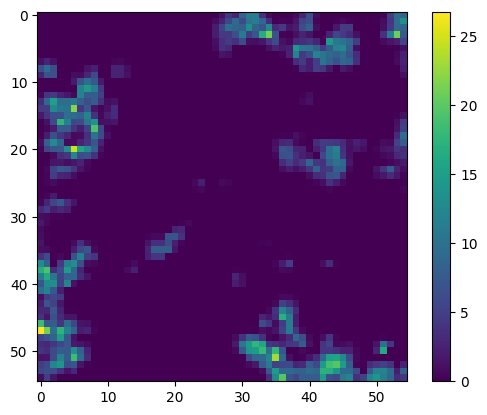

unique values: [0.00000000e+00 6.61530569e-04 1.10255092e-03 1.76408157e-03
 1.98459171e-03 2.20510185e-03 2.64612228e-03 3.30765277e-03
 3.30765285e-03 3.52816314e-03 3.96918342e-03 3.96918356e-03
 4.63071398e-03 5.29224470e-03 5.73326468e-03 5.95377512e-03
 6.17428541e-03 6.61530554e-03 7.05632627e-03 7.71785647e-03
 8.37938726e-03 8.59989703e-03 8.82040739e-03 8.82040784e-03
 9.92295831e-03 1.16870403e-02 1.19075507e-02 1.21280602e-02
 1.21280611e-02 1.23485708e-02 1.32306111e-02 1.54357129e-02
 1.58767343e-02 1.65382639e-02 1.71997941e-02 1.76408148e-02
 1.85228562e-02 1.98459166e-02 1.98459172e-02 2.11689788e-02
 2.20510185e-02 2.29330587e-02 2.29330604e-02 2.31535697e-02
 2.33740807e-02 2.42561221e-02 2.64612219e-02 2.64612222e-02
 2.77842832e-02 2.99893866e-02 3.08714271e-02 3.17534685e-02
 3.17534687e-02 3.19739771e-02 3.21944880e-02 3.30765295e-02
 3.50611210e-02 3.63841820e-02 3.77072430e-02 3.79277512e-02
 3.96918344e-02 4.05738735e-02 4.18969363e-02 4.56456077e-02
 4.851224

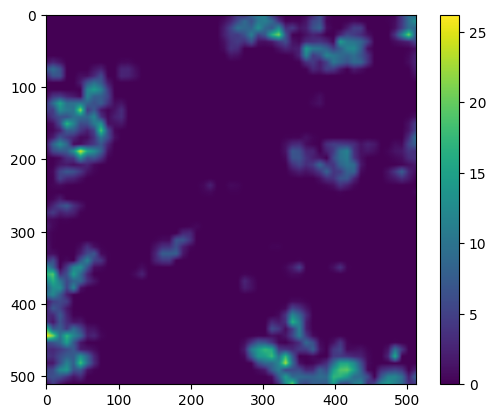

unique values: [0.00000000e+00 8.98521550e-07 9.86346959e-07 ... 2.56212650e+01
 2.60677595e+01 2.61972783e+01]
/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/POP/Sen1floods11/USA_5510883_S1Weak_label.npy
[[0.         0.         0.01238467 ... 0.         0.         0.00183395]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


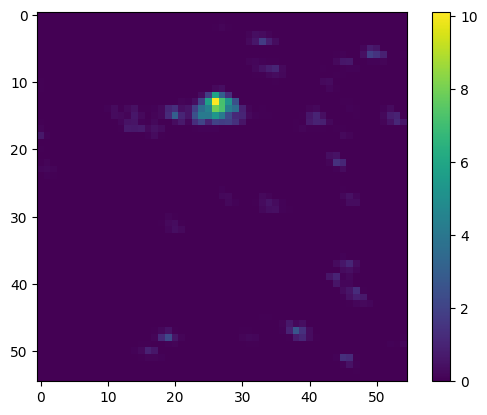

unique values: [0.00000000e+00 8.26435684e-06 2.20382855e-05 3.30574274e-05
 3.42663455e-05 4.13217842e-05 4.40765709e-05 5.33595933e-05
 5.50957112e-05 6.47393495e-05 6.61148564e-05 6.85326910e-05
 7.17707121e-05 7.92698961e-05 9.13769214e-05 1.14621698e-04
 1.29478699e-04 1.37065382e-04 1.40284822e-04 1.77865311e-04
 1.82980186e-04 1.86603853e-04 1.89492285e-04 2.14873278e-04
 2.16562611e-04 2.19576242e-04 2.20382855e-04 2.37809675e-04
 2.53663657e-04 2.56126048e-04 2.58957398e-04 3.23696748e-04
 3.43865094e-04 3.78984570e-04 3.80495486e-04 3.88436097e-04
 4.07708291e-04 4.62803994e-04 5.13995170e-04 5.59811558e-04
 5.61139288e-04 6.34159143e-04 7.57969140e-04 7.68516834e-04
 7.76872194e-04 8.11212205e-04 8.22392292e-04 8.66250445e-04
 9.06350893e-04 9.16973584e-04 9.39128843e-04 9.51238753e-04
 9.88093088e-04 1.03050864e-03 1.03159528e-03 1.10056894e-03
 1.12227858e-03 1.13695371e-03 1.15734049e-03 1.18280429e-03
 1.22326942e-03 1.23004764e-03 1.24299549e-03 1.26083868e-03
 1.268318

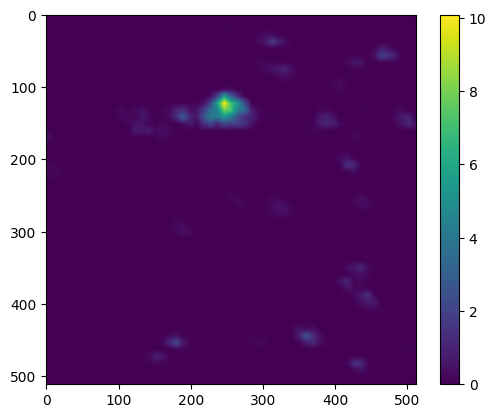

unique values: [0.00000000e+00 3.16495297e-09 5.70648119e-09 ... 9.80675233e+00
 9.87121614e+00 1.00889899e+01]
/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/POP/Sen1floods11/Somalia_9757143_S1Weak_label.npy
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         2.12227356 0.79585258 ... 0.         0.         0.        ]
 [0.         0.38908349 0.20338455 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.4089798  1.96199768 0.54714867]
 [0.         0.         0.         ... 2.21070166 2.35439724 2.10016665]
 [0.         0.         0.         ... 1.66355303 0.26749491 2.35881876]]


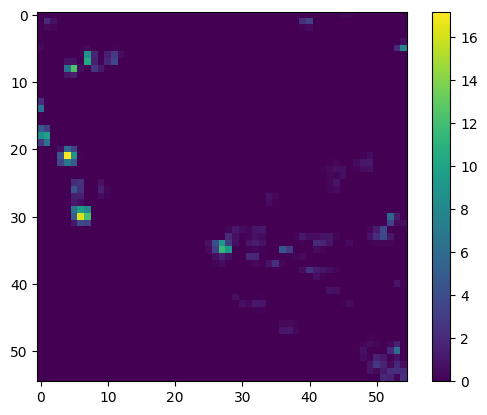

unique values: [0.00000000e+00 3.31605256e-03 5.52675426e-03 6.63210511e-03
 8.84280682e-03 9.94815767e-03 1.65802622e-02 1.65802628e-02
 1.76856136e-02 2.21070170e-02 2.32123679e-02 2.54230690e-02
 2.76337695e-02 3.31605244e-02 3.64765763e-02 4.20033312e-02
 4.42140341e-02 4.75300837e-02 4.97407883e-02 5.08461368e-02
 5.30568409e-02 5.52675390e-02 5.74782419e-02 5.96889460e-02
 6.07942963e-02 6.18996477e-02 6.41103458e-02 6.63210487e-02
 6.96371031e-02 7.18478024e-02 7.51638556e-02 7.62692070e-02
 7.73745596e-02 8.29013085e-02 8.40066624e-02 8.62173629e-02
 9.72708750e-02 1.02797625e-01 1.02797627e-01 1.08324380e-01
 1.14956486e-01 1.32642097e-01 1.39274207e-01 1.42590251e-01
 1.43695605e-01 1.43695611e-01 1.45906305e-01 1.54749117e-01
 1.58065165e-01 1.65802631e-01 1.68013325e-01 1.72434731e-01
 1.74645424e-01 1.74645429e-01 1.75750780e-01 1.76856136e-01
 1.82382889e-01 1.82382889e-01 1.83488235e-01 1.85698943e-01
 1.90120335e-01 1.92331038e-01 1.93436387e-01 1.98963146e-01
 1.989631

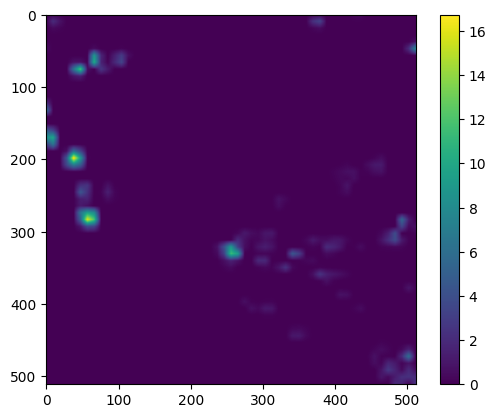

unique values: [0.00000000e+00 2.13348153e-06 3.42880947e-06 ... 1.59014459e+01
 1.61873986e+01 1.67390456e+01]


In [ ]:
# look at the labels

for file in Path('/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/POP/Sen1floods11').iterdir():
  # Load the NumPy array
  if file.is_file() and file.suffix == '.npy':
    print(file)
    data = np.load(file)

    # Print or process the data
    print(data)
    np.unique(data)
    plt.imshow(data)
    plt.colorbar()
    plt.show()
    print(f'unique values: {np.unique(data)}')

In [ ]:
save_array_of_problematic_images(save_dir, list_of_files_in_multiple_tiles)
